# This PR plots montages of temporal data for a single cell followed through time.

## Imports

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tifffile
from PIL import Image, ImageDraw, ImageEnhance, ImageFont

## Functions

In [2]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to the range [0, 255] and convert to uint8.

    Parameters
    ----------
    image : np.ndarray
        Input image to be normalized.

    Returns
    -------
    np.ndarray
        Normalized image in uint8 format.
    """
    image = image.astype(np.float32)
    image -= image.min()
    image /= image.max()
    image *= 255.0
    return image.astype(np.uint8)


# make the composite images
def make_composite_image(
    image1_path: pathlib.Path,  # yellow
    image2_path: pathlib.Path,  # green
) -> PIL.Image.Image:
    """
    Create a composite image from four input images.

    Parameters
    ----------
    image1_path : pathlib.Path
        Path to the first image (DNA).
    image2_path : pathlib.Path
        Path to the second image (AnnexinV).

    Returns
    -------
    PIL.Image.Image
        Composite image in CYMK format. Where the channels are:
        - C: DNA (blue)
        - M: AnnexinV (red)
    """
    # Load the images
    image1 = tifffile.imread(image1_path)  # DNA
    image2 = tifffile.imread(image2_path)  # AnnexinV

    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)

    # Normalize the images to the range [0, 255]
    image1 = normalize_image(image1)  # DNA
    image2 = normalize_image(image2)  # AnnexinV

    enhancer = ImageEnhance.Contrast(Image.fromarray(image1))
    image1 = np.array(enhancer.enhance(3))  # Increase contrast

    enhancer = ImageEnhance.Contrast(Image.fromarray(image2))
    image2 = np.array(enhancer.enhance(3))  # Increase contrast
    # # convert the PIL.Image back to numpy array
    # image2 = np.array(image2)

    # make a cyan, magenta, yellow composite
    # cyan = green + blue
    # magenta = red + blue
    # yellow = red + green
    # composite = max(cyan, magenta, yellow)
    cyan = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
    cyan[..., 1] = image1  # green
    cyan[..., 2] = image1  # blue
    magenta = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
    magenta[..., 0] = image2  # red
    magenta[..., 2] = image2  # blue

    composite = np.maximum(cyan, magenta)
    # Convert to PIL Image for enhancement
    composite = Image.fromarray(composite)
    enhancer = ImageEnhance.Contrast(composite)
    composite = enhancer.enhance(4)  # Increase contrast
    return composite


def generate_image_pannel_df(df: pd.DataFrame, well_fov: str) -> pd.DataFrame:
    """
    Generate a DataFrame containing composite images for a specific cell over time.


    Parameters
    ----------
    df : pd.DataFrame
        Image-based profile DataFrame.
    well_fov : str
        Well and field of view identifier.
    dose : float
        Dosage of treatment.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns: well_fov, composite, dose.
    """
    output_dict = {
        "well_fov": [],
        "composite": [],
        "dose": [],
    }
    tmp_df = df.loc[(df["Metadata_Well_FOV"] == well_fov)]
    try:
        for index, row in tmp_df.iterrows():
            well_fov = row["Metadata_Well_FOV"]
            image1_path = pathlib.Path(row["Metadata_Image_FileName_DNA_full"]).resolve(
                strict=True
            )
            image2_path = pathlib.Path(
                row["Metadata_Image_FileName_AnnexinV_full"]
            ).resolve(strict=True)
            composite_image = scale_image(
                make_composite_image(
                    image1_path=image1_path,
                    image2_path=image2_path,
                )
            )
            output_dict["well_fov"].append(well_fov)
            output_dict["composite"].append(composite_image)
            output_dict["dose"].append(row["Metadata_dose"])
    except Exception as e:
        print(f"Error processing well_fov {well_fov}: {e}")
    output_df = pd.DataFrame(output_dict)
    # sort by time
    return output_df


# scale the images up for better visualization
def scale_image(image: PIL.Image.Image, scale_factor: int = 4) -> PIL.Image.Image:
    """
    Scale the image by a given factor using nearest neighbor interpolation.

    Parameters
    ----------
    image : PIL.Image.Image
        Input image to be scaled.
    scale_factor : int, optional
        Scaling factor, by default 4

    Returns
    -------
    PIL.Image.Image
        Scaled image for better visualization.
    """

    width, height = image.size
    new_size = (int(width * scale_factor), int(height * scale_factor))
    return image.resize(new_size, Image.NEAREST)

## Pathing and preprocessing

In [3]:
umap_file_path = pathlib.Path(
    "../../../data/CP_feature_select/endpoints/features_selected_profile.parquet"
).resolve(strict=True)

montage_background_output_dir = pathlib.Path(
    "../figures/terminal_montage.png"
).resolve()

montage_background_output_dir.parent.mkdir(parents=True, exist_ok=True)
df = pd.read_parquet(umap_file_path)
df["Metadata_Well_FOV"] = df["Metadata_Well"] + "_F" + df["Metadata_FOV"].astype(str)
# pd.set_option("display.max_columns", None)
df["Metadata_Image_PathName_AnnexinV"][0]
df["Metadata_Image_FileName_AnnexinV_full"] = df.apply(
    lambda row: pathlib.Path(
        f'/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{row["Metadata_Well"]}_F{row["Metadata_FOV"]}',
        row["Metadata_Image_FileName_AnnexinV"],
    ),
    axis=1,
)
df["Metadata_Image_FileName_DNA_full"] = df.apply(
    lambda row: pathlib.Path(
        f'/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{row["Metadata_Well"]}_F{row["Metadata_FOV"]}',
        row["Metadata_Image_FileName_DNA"],
    ),
    axis=1,
)

df.sort_values(by=["Metadata_Well_FOV"], inplace=True)
df.drop_duplicates(subset=["Metadata_Well_FOV"], inplace=True)

df.reset_index(drop=True, inplace=True)
df.head()

,Metadata_plate,Metadata_Well,Metadata_number_of_singlecells,Metadata_compound,Metadata_dose,Metadata_control,Metadata_ImageNumber,Metadata_FOV,Metadata_Time,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Correlation_AnnexinV_3_03_256,Nuclei_Texture_Correlation_DNA_3_02_256,Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Nuclei_Texture_SumAverage_DNA_3_01_256,Metadata_Well_FOV,Metadata_Image_FileName_AnnexinV_full,Metadata_Image_FileName_DNA_full
0,1,C-02,155,Staurosporine,0.00,negative,1,0001,13.0,105.0,...,-0.672238,0.643979,1.007621,0.751432,0.474450,-0.017445,0.347586,C-02_F0001,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...
1,1,C-02,179,Staurosporine,0.00,negative,1,0002,13.0,48.0,...,1.720537,-1.632944,1.363801,0.758162,-2.189775,-0.020130,-2.011676,C-02_F0002,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...
2,1,C-02,158,Staurosporine,0.00,negative,1,0003,13.0,93.0,...,-0.666071,0.643979,-1.267717,-1.853163,0.474450,-1.437757,0.347586,C-02_F0003,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...
3,1,C-02,146,Staurosporine,0.00,negative,1,0004,13.0,98.0,...,-0.666071,0.643979,-1.267717,-1.853163,0.474450,-1.437757,0.347586,C-02_F0004,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...
4,1,C-03,172,Staurosporine,0.61,test,1,0001,13.0,36.0,...,-0.676631,0.643979,1.071410,0.746659,0.474450,-0.013829,0.347586,C-03_F0001,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...


## Get dfs containing cell tracks

In [4]:
c02_df = generate_image_pannel_df(df, "C-02_F0003")  # DMSO
c03_df = generate_image_pannel_df(df, "C-03_F0003")  # 0.61
c04_df = generate_image_pannel_df(df, "C-04_F0003")  # 1.22
c05_df = generate_image_pannel_df(df, "C-05_F0003")  # 2.44
c06_df = generate_image_pannel_df(df, "C-06_F0003")  # 4.88
c07_df = generate_image_pannel_df(df, "C-07_F0003")  # 9.77
c08_df = generate_image_pannel_df(df, "C-08_F0003")  # 19.23
c09_df = generate_image_pannel_df(df, "C-09_F0003")  # 39.06
c10_df = generate_image_pannel_df(df, "C-10_F0003")  # 78.13
c11_df = generate_image_pannel_df(df, "C-11_F0003")  # 156.25
all_dfs = pd.concat(
    [
        c02_df,
        c03_df,
        c04_df,
        c05_df,
        c06_df,
        c07_df,
        c08_df,
        c09_df,
        c10_df,
        c11_df,
    ],
    ignore_index=True,
)

## Full montage of all timepoints and all doeses

<Figure size 640x480 with 0 Axes>

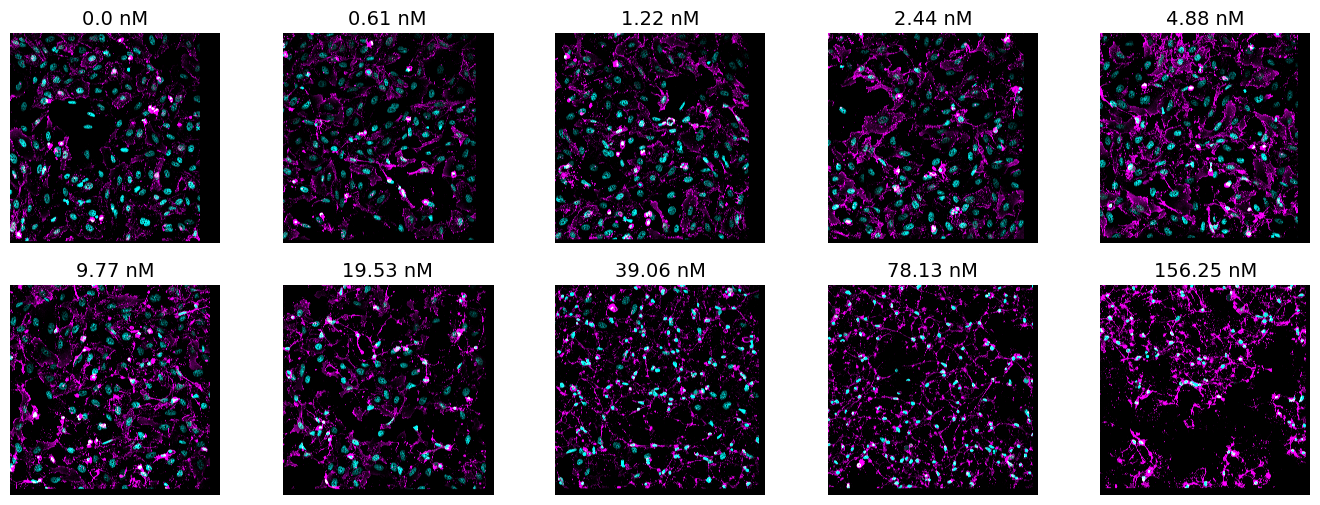

In [6]:
# create a montage of the images in composite_df
plt.subplots_adjust(wspace=0, hspace=0)
plt.figure(figsize=(17, 6))
for index, row in all_dfs.iterrows():
    plt.subplot(2, int(len(all_dfs) / 2), index + 1)
    plt.imshow(row["composite"])
    plt.title(f"{row['dose']} nM", fontsize=14)
    plt.axis("off")
plt.savefig(montage_background_output_dir, dpi=600, pad_inches=0.1, bbox_inches="tight")
plt.show()